In [6]:
import pandas as pd
import numpy as np
import plotly.express as px 
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Veri Setini Okuma

In [7]:
#Veri setini okuma
data=pd.read_csv("C:/Users/tgbnr/Downloads/heart_failure_clinical_records.csv")

In [8]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


In [9]:
#Boş değerleri kontrol etme
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

## Aykırı Değer Analizi

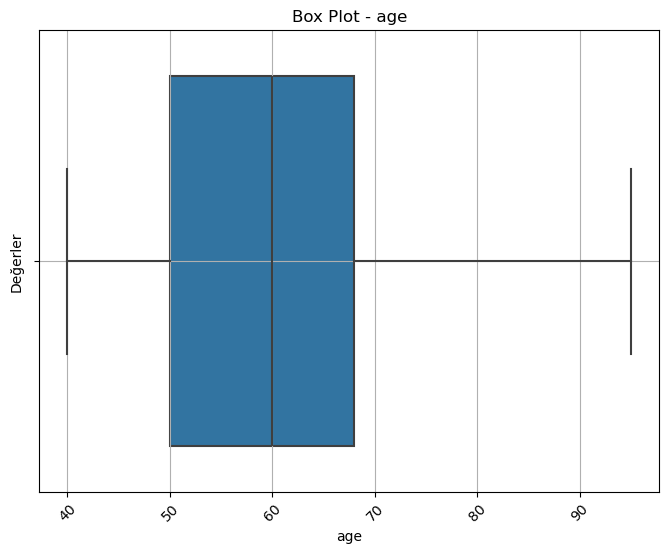

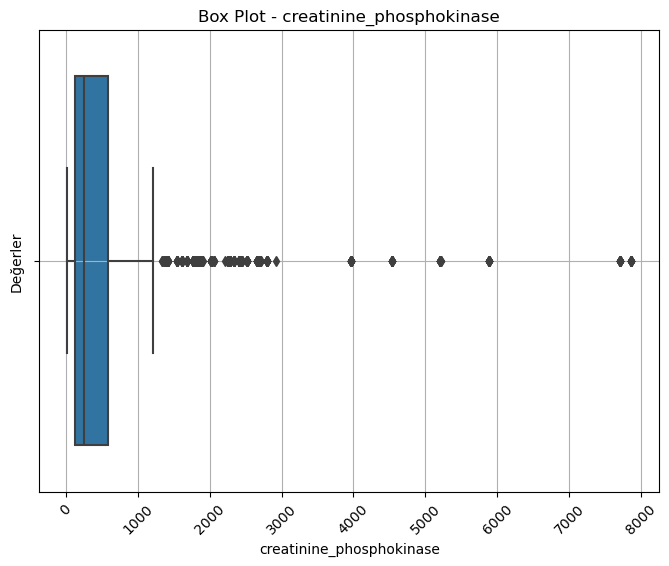

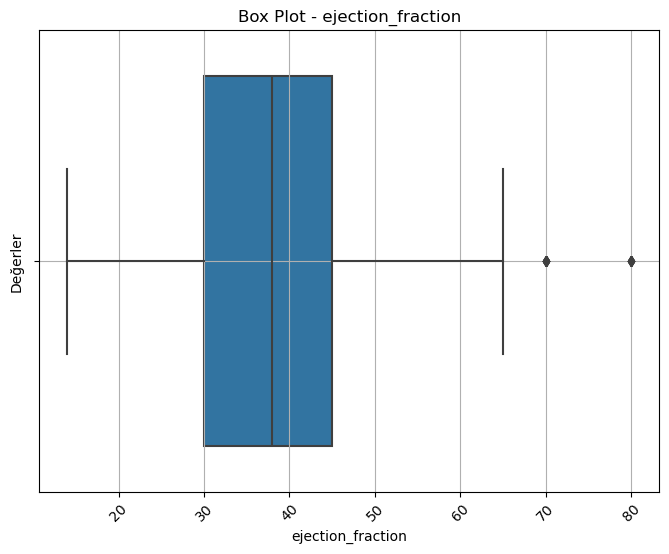

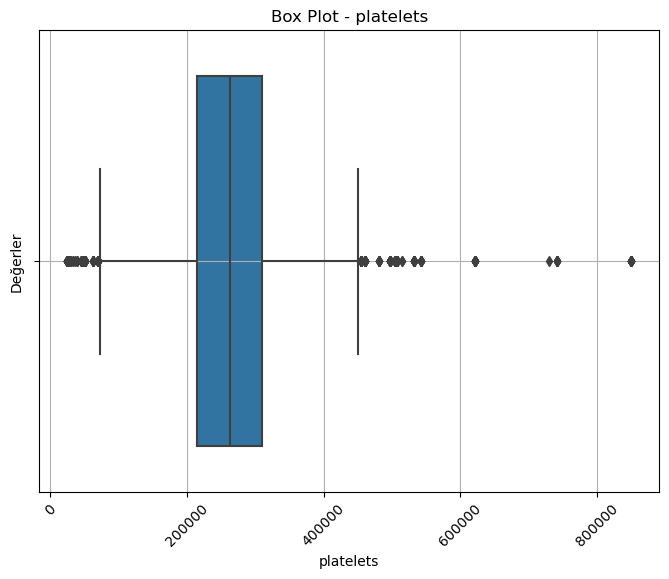

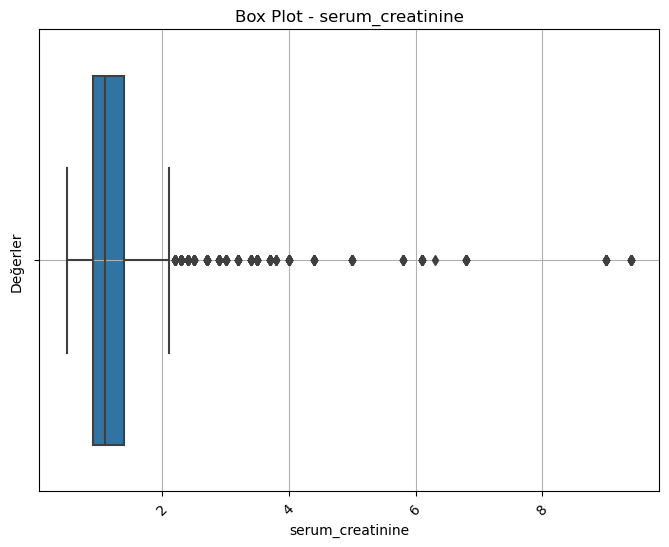

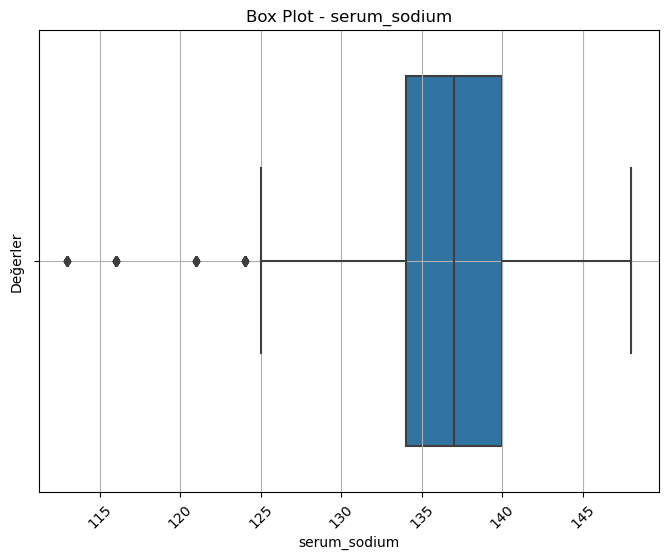

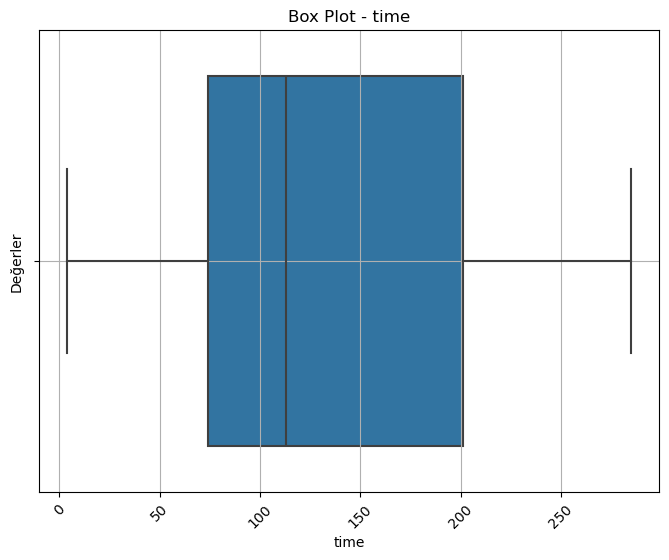

In [10]:
#Sayısal değerler için aykırı değer analizi
num_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
            'platelets', 'serum_creatinine', 'serum_sodium', 'time']
for column in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot - {column}')
    plt.xlabel(column)
    plt.ylabel('Değerler')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [11]:
outlier_cols = ['creatinine_phosphokinase', 'ejection_fraction',
                'platelets', 'serum_creatinine', 'serum_sodium']
outlier_list = []

for i in outlier_cols:
    Q1 = data[i].quantile(0.25)
    Q3 =data[i].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = IQR * 1.5
    index_list = data[(data[i] < (Q1 - outlier_step)) | (data[i] > (Q3 + outlier_step))].index
    outlier_list.extend(index_list)
    
outlier_list = Counter(outlier_list)
outlier_list = list(outlier_list.items())
multi_outlier_indexes = [key for key, value in outlier_list if value > 1]

print(f"Aykırı değerlerin olduğu satırların sayısı: {len(outlier_list)}")
print(f"Birden fazla değişkende aykırı değere sahip satırların sayısı :{len(multi_outlier_indexes)}")

Aykırı değerlerin olduğu satırların sayısı: 1172
Birden fazla değişkende aykırı değere sahip satırların sayısı :148


In [12]:
#Aykırı değerlerin olduğu satırları silme işlemi
data.drop(multi_outlier_indexes, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

## Normalizasyon İşlemi


In [13]:
#Normalizasyon işlemi
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
data = pd.DataFrame(normalized_data, columns=data.columns)
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,0.272727,0.0,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,1.0,0.298932,0.0
1,0.454545,0.0,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,1.0,0.0,0.722420,0.0
2,0.090909,0.0,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.0,0.854093,0.0
3,0.363636,1.0,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,1.0,0.0,0.306050,0.0
4,1.000000,1.0,0.071319,0.0,0.242424,0.0,0.528428,0.168539,0.542857,1.0,0.0,0.163701,1.0


In [14]:
#Hedef değişkeni ayrıştırma
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

### Özellik Seçim Yöntemi 1


## Korelasyon Matrisi Yöntemi

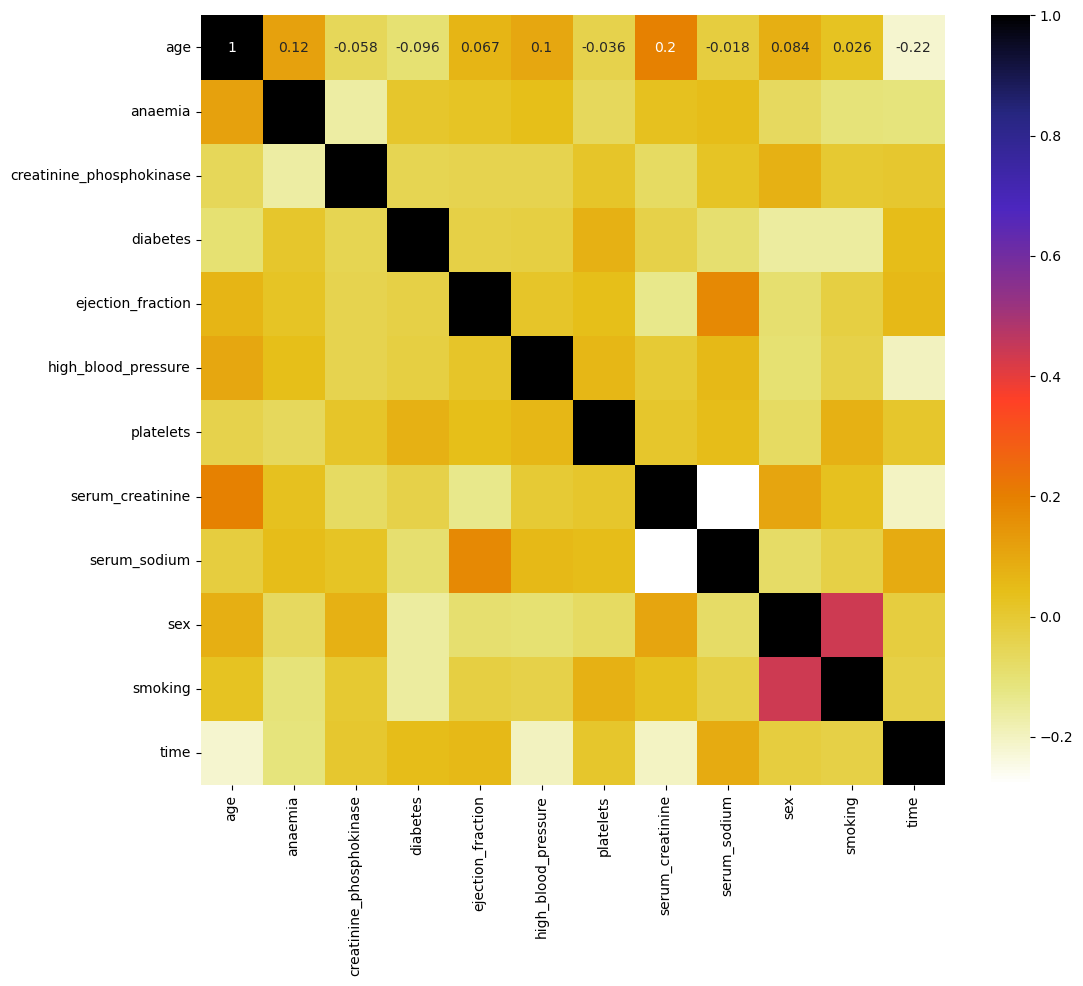

In [15]:
#Korelasyon matrisi 
X.corr()
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [16]:
#Yüksek korelasyonlu özelliği tespit etme fonksiyonu
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
    return col_corr

In [17]:
#Çıkarılacak özelliği belirleme
corr_features = correlation(X, 0.4)
print(len(set(corr_features)))
print(corr_features)
X.drop(corr_features,axis=1)

1
{'smoking'}


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,time
0,0.272727,0.0,0.092498,0.0,0.469697,0.0,0.288833,0.089888,0.685714,1.0,0.298932
1,0.454545,0.0,0.004210,0.0,0.166667,0.0,0.339314,0.505618,0.485714,1.0,0.722420
2,0.090909,0.0,0.071319,1.0,0.363636,0.0,0.356286,0.044944,0.771429,0.0,0.854093
3,0.363636,1.0,0.093264,1.0,0.393939,1.0,0.367196,0.078652,0.371429,1.0,0.306050
4,1.000000,1.0,0.071319,0.0,0.242424,0.0,0.528428,0.168539,0.542857,1.0,0.163701
...,...,...,...,...,...,...,...,...,...,...,...
4847,0.363636,1.0,0.071319,0.0,0.242424,1.0,0.123530,0.044944,0.914286,0.0,0.323843
4848,0.090909,0.0,0.071319,1.0,0.621212,0.0,0.627834,0.056180,0.542857,0.0,0.875445
4849,0.363636,1.0,0.071319,0.0,0.242424,1.0,0.123530,0.044944,0.914286,0.0,0.323843
4850,1.000000,1.0,0.011355,0.0,0.393939,1.0,0.207177,0.056180,0.714286,0.0,0.071174


## Veri setini Eğitim ve Test setlerine ayırma

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Makine Öğrenim Yöntemi 1 

## KNN Modeli

In [19]:
# KNN modelini oluşturma
k = 5 #komşu sayısı
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [20]:
# Test seti üzerinde tahmin yapma
y_pred = knn_classifier.predict(X_test)

In [21]:
# Modelin doğruluğunu değerlendirme
accuracy = accuracy_score(y_test, y_pred)
print("Test doğruluğu:", accuracy)

Test doğruluğu: 0.9526098901098901


In [22]:
# K değerlerini belirleme
k_values = list(range(1, 21))

# Çapraz doğrulama ile k değerlerinin performansını değerlendirme
mean_scores = []
for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X, y, cv=5)  # 5 katlı çapraz doğrulama
    mean_scores.append(np.mean(scores))

### Modelin doğruluk oranı

In [23]:
# En iyi k değerini bulma
best_k = k_values[np.argmax(mean_scores)]
best_score = max(mean_scores)

# En iyi k değerini ve doğruluk değerini yazdırma
print(f"En iyi k değeri: {best_k}")
print(f"Doğruluk: {best_score}")

En iyi k değeri: 2
Doğruluk: 0.9676583817299628


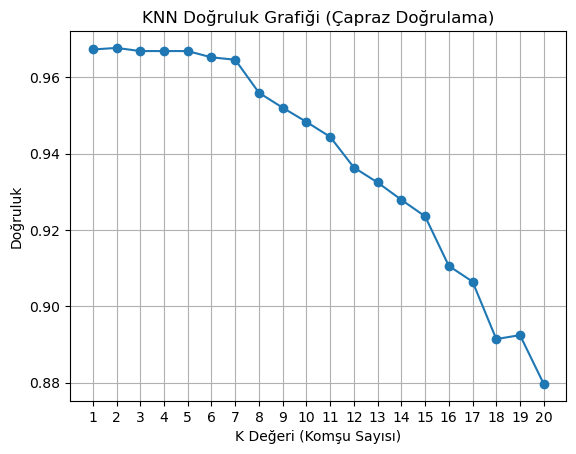

In [24]:
# Doğruluk grafiğini çizme
plt.plot(k_values, mean_scores, marker='o', linestyle='-')
plt.title('KNN Doğruluk Grafiği (Çapraz Doğrulama)')
plt.xlabel('K Değeri (Komşu Sayısı)')
plt.ylabel('Doğruluk')
plt.xticks(np.arange(1, 21, step=1))
plt.grid(True)
plt.show()

## Karışıklık Matrisi

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[980,  24],
       [ 45, 407]], dtype=int64)

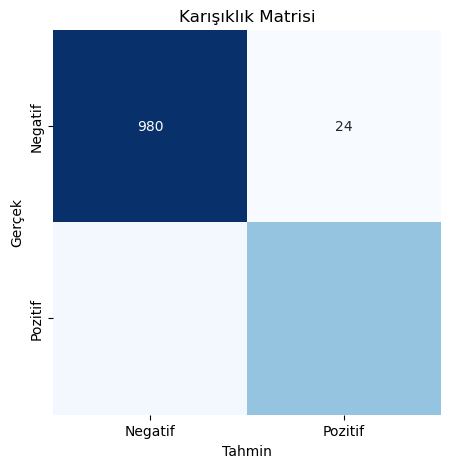

In [26]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negatif', 'Pozitif'], yticklabels=['Negatif', 'Pozitif'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

## Model Değerlendirme

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score
# Sınıflandırma raporunu yazdırma
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9526
Precision: 0.9443
Recall: 0.9004
F1 Score: 0.9219


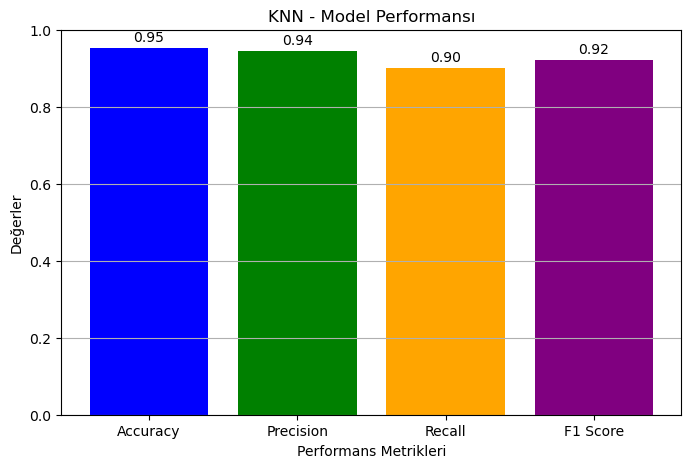

In [28]:
#Model değerlendirme sonuçlarının grafikle gösterme
#Metrikleri listeye ekleme
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1]
#Grafik oluşturma
plt.figure(figsize=(8, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'purple'])
plt.xlabel('Performans Metrikleri')
plt.ylabel('Değerler')
plt.title('KNN - Model Performansı')
plt.ylim(0, 1)  #Değerlerin aralığını 0 ile 1 arasında sınırla
plt.grid(axis='y') 

#Değerleri yazdırma
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)